Synthesizing [adversarial examples](https://arxiv.org/abs/1312.6199) for neural networks is surprisingly easy: small, carefully-crafted perturbations to inputs can cause neural networks to misclassify inputs in arbitrarily chosen ways.

# Setup

We choose to attack an [Inception v3](https://arxiv.org/abs/1512.00567) network trained on [ImageNet](http://www.image-net.org/). In this section, we load a pre-trained network from the [TF-slim image classification library](https://github.com/tensorflow/models/tree/master/slim).

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

/Users/jennyxue/Documents/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

First, we set up the input image to the classifier.

In [3]:
x = tf.placeholder(tf.float32, (299, 299, 3))

Next, we load the Inception v3 model.

In [4]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(x, reuse=False)

Above, `logits` is the output of the classifier. Logits are pre-softmax values, so to get an actual probability distribution, we'd have to compute `softmax(logits)`.

Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.

In [5]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [6]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [7]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

Next, we write some code to show an image, classify it, and show the classification result.

In [8]:
import json
import matplotlib.pyplot as plt

In [9]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [10]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={x: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

We load our example image and make sure it's classified correctly.

In [11]:
import PIL
import numpy as np

Feel free to use a different image below! If you need help figuring out the ImageNet class ID of your image, you can consult [this list](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [12]:
img_path, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_class = 281 # true class
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

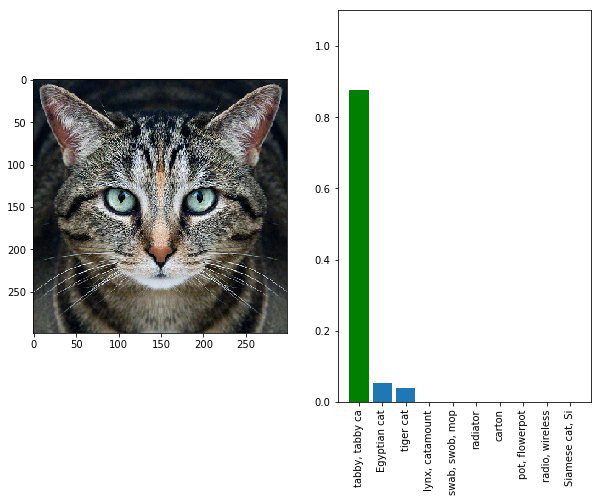

In [13]:
classify(img, correct_class=img_class)

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ box with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](http://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Defining $\log P(y \mid x)$

Our code above gives us `logits`, which are the pre-softmax outputs of the classifier. To turn that into probabilities, and in particular, to compute $- \log P(y \mid x)$, we can use `tf.nn.sparse_softmax_cross_entropy_with_logits` (the reason for using this as opposed to using `softmax()` and then `log()` has to do with numerical stability).

In [14]:
y = tf.placeholder(tf.int32, ()) # the adversarial target class
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[y])
# loss is now - log P (y | x)

## Defining the gradient

In [15]:
grad, = tf.gradients(loss, x)

`grad` is now a tensor representing $\nabla - \log P(y \mid x)$.

## Running projected gradient descent (PGD)

Finally, we want to run the algorithm described above, where we alternate between gradient descent steps and projection steps.

Some hints on how to use NumPy / TensorFlow to compute things that will be useful:

In [16]:
# you can evaluate the gradient at a point by running:
g = grad.eval({x: img, y: 123}) # what does the `y : 123` mean?

# you can evaluate - log P(y | x) at a point by running:
l = loss.eval({x: img, y: 123})
# this can be useful for debugging

# you can evaluate multiple tensors at once by running:
g, l = sess.run([grad, loss], {x: img, y: 123})

# you can clip a value by running:
ex_clipped = np.clip([-0.1, 0.2, 0.7, 1.3], 0, 1)

In [78]:
# attack parameters, feel free to experiment with these
EPSILON = 0.1
TARGET_CLASS = 924
PGD_STEPS = 10
STEP_SIZE = 0.4

In [79]:
# TODO implement the attack here to compute the adversarial example, ending up with the final result in `adv`

adv = np.copy(img) # initialize adversarial example with original image

for step in range(PGD_STEPS):
    g = grad.eval({x: adv, y: TARGET_CLASS})
    adv = adv - STEP_SIZE * g
    adv = np.clip(adv, img - EPSILON, img + EPSILON)
# ...

## Evaluating the adversarial example

Let's see if it worked:

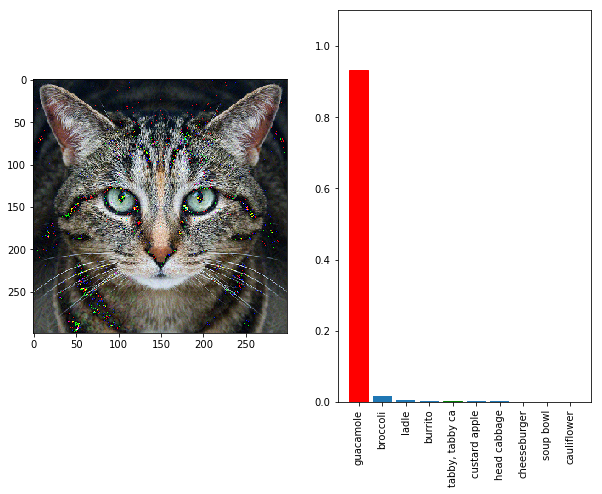

In [80]:
classify(adv, correct_class=img_class, target_class=TARGET_CLASS)

# Other things to try

- Can you make an untargeted adversarial example? (find an image that's misclassified, but you don't care which class it's misclassified as, as long as it's not the true class).
- Can you find a way to defend against adversarial examples? Perhaps try to find a function `purify(x)` that you use to preprocess images before you pass them to `classify(x)`? Some ideas to try are reducing the bit-depth of the image or JPEG-compressing the image.